In [1]:
import os
from glob import glob
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as mpatches

from cascade.learning.torchani import TorchANI
from pathlib import Path
from ase.io import read
from ase import units
import pickle as pkl
import pandas as pd
import numpy as np
import json

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mike/miniconda3/envs/cascade/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
run_dirs = sorted(glob('runs/800K-npt-single-train/si*temp=*00*blend*'))
run_dirs

['runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-00e6f7df',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-05bd7fef',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-0aff6fba',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-105292bb',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1418cfda',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-160f5dc6',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-1ffe8b75',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-24aacf2b',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-2fc33503',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-399f3417',
 'runs/800K-npt-single-train/si-vacancy-2x2x2-temp=800.0-method=lda-blend=0-3c135b25',
 'runs/800K-npt-single-train/si-vacancy-2x2

In [3]:
params = []
for d in run_dirs:
    try:
        params.append(json.loads((Path(d)/'params.json').read_text()))
    except: 
        print(f'couldnt find {d}/params.json; skipping')
        continue
    params[-1]['dir'] = d
params = pd.DataFrame(params)
params.shape

(114, 30)

In [4]:
params = params.query('min_target_frac == 0.1 or min_target_frac == 1')
params = params.query('n_blending_steps == 0 or n_blending_steps == 10')
params = params.query('target_error != 0.45')

In [5]:
meth = []
for i, row in params.iterrows():
    if row['n_blending_steps'] == 0 and row['min_target_frac'] == 1:
        meth.append('DFT (reference)')
    elif row['n_blending_steps'] == 0: 
        meth.append('Proxima')
    else: 
        meth.append('Proxima+blend')
params['Method'] = pd.Categorical(meth, categories=['Proxima', 'Proxima+blend', 'DFT (reference)'])

In [6]:
param_vars = ['seed', 'temperature', 'n_blending_steps', 'min_target_frac', 'target_error', 'stress_tau', 'steps']
_params = params[param_vars].sort_values(param_vars)
_params.describe()

,seed,temperature,n_blending_steps,min_target_frac,target_error,stress_tau,steps
count,18.000000,18.0,18.000000,18.000000,1.800000e+01,18.0,18.0
mean,2.500000,800.0,3.333333,0.400000,6.000000e-01,25.0,2048.0
std,1.757338,0.0,4.850713,0.436564,4.365641e-01,0.0,0.0
min,0.000000,800.0,0.000000,0.100000,1.000000e-12,25.0,2048.0
25%,1.000000,800.0,0.000000,0.100000,1.000000e-12,25.0,2048.0
50%,2.500000,800.0,0.000000,0.100000,9.000000e-01,25.0,2048.0
75%,4.000000,800.0,10.000000,1.000000,9.000000e-01,25.0,2048.0
max,5.000000,800.0,10.000000,1.000000,9.000000e-01,25.0,2048.0


In [7]:
_params

,seed,temperature,n_blending_steps,min_target_frac,target_error,stress_tau,steps
15,0,800.0,0,0.1,9.000000e-01,25.0,2048
4,0,800.0,0,1.0,1.000000e-12,25.0,2048
77,0,800.0,10,0.1,9.000000e-01,25.0,2048
35,1,800.0,0,0.1,9.000000e-01,25.0,2048
14,1,800.0,0,1.0,1.000000e-12,25.0,2048
46,1,800.0,10,0.1,9.000000e-01,25.0,2048
3,2,800.0,0,0.1,9.000000e-01,25.0,2048
18,2,800.0,0,1.0,1.000000e-12,25.0,2048
44,2,800.0,10,0.1,9.000000e-01,25.0,2048
20,3,800.0,0,0.1,9.000000e-01,25.0,2048


In [8]:
assert not _params.duplicated().any()

## Read all of the trajectory data into one dataframe

In [9]:
data = []
hashes = []
for i, row in params.iterrows(): 
    # read in the results for each set of parameters
    run = row['dir']
    try:
        _data = pd.read_json(Path(run)/'proxima-log.json', lines=True)
    except: 
        print('couldnt read proxima log for', run)
        hashes.append(None)
        continue
    # make sure to have timestep
    _data.reset_index(names='timestep', inplace=True)

    # keep the hash of the run
    _hash = run.split('-')[-1]
    hashes.append(_hash)
    _data['hash'] = _hash 
    #traj = read(Path(run)/'md.traj', index=':')
    #break    
    # add the parameters to the experiment df for easy plotting, grouping, etc
    for var in param_vars:
        _data[var] = row[var]
    data.append(_data)

# track the hashes as well for param lookup
params['hash'] = hashes
data = pd.concat(data)

## Volume gradients and Runtimes

In [10]:
v_diff = []
for _hash, g  in data.groupby('hash'):
    diff = g['volume'].diff().abs()
    v_diff.append((_hash, diff.max(), diff.mean(), diff.std()))
v_diff = pd.DataFrame.from_records(v_diff, columns=['hash', 'diff_max', 'diff_mean', 'diff_sd'])

In [11]:
params = pd.merge(params, v_diff, on='hash')

In [12]:
runtimes = []
for _hash, g  in data.groupby('hash'):
    #g = g.query('model_version > 0')
    n_target_evals = g['target_invocations'].max() / g['total_invocations'].max()
    runtime = g['step_time'].sum()
    runtimes.append((_hash, runtime, n_target_evals))
runtimes = pd.DataFrame.from_records(runtimes, columns=['hash', 'runtime', 'target_evals'])

In [13]:
params = pd.merge(params, runtimes, on='hash')

In [14]:
params['runtime_h'] = params['runtime'] / (60*60)

## volume and density

In [15]:
v_mean = data.query('timestep > 1536').groupby('hash')['volume'].mean().reset_index()

In [16]:
params = pd.merge(params, v_mean, on='hash')

In [17]:
ang_3_to_cm_3 = 1e-24
Si_mm = 28.0855 # g / mol
N_av = 6.02e23 # n / mol

In [18]:
rho = 63 / params['volume'] # n / ang_3
rho = rho * Si_mm / N_av / ang_3_to_cm_3
params['density'] = rho

/tmp/ipykernel_212343/1814673006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data['Method'] = _data['Method'].cat.remove_unused_categories()


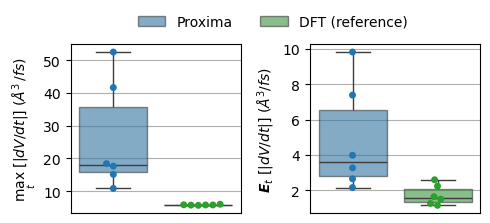

In [44]:
_data = params.query('Method != "Proxima+blend"')
_data['Method'] = _data['Method'].cat.remove_unused_categories()

fig, axs = plt.subplots(1, 2, figsize=(5,2))
labels = ['$\max_t$ $[|dV/dt|]$ ($\AA^3/fs$)', 
          r'$\boldsymbol{E}_t$ $[|dV/dt|]$ ($\AA^3/fs$)']
for i, var in enumerate(['diff_max', 'diff_mean']):
    plt.sca(axs[i])
    ax = plt.gca()
    sns.boxplot(x='Method', 
                y=var,
                data=_data,
                hue='Method',
                boxprops=dict(alpha=.6),
                showfliers=False,
                legend=i,
                ax=ax,
                palette = ['tab:blue', 'tab:green'],
               )
    sns.swarmplot(x='Method', 
                y=var,
                data=_data,
                hue='Method',
                ax=ax,
                palette = ['tab:blue', 'tab:green'],
                #marker='Method',
               )
    plt.ylabel(labels[i])
    plt.xlabel('')
    plt.xticks([])
    plt.grid('on', which='both')
    # plt.legend()
    #plt.ylim(bottom=0)
plt.tight_layout()
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor=(0.65, 1.25), ncol=3, title=None, frameon=False,
)
plt.savefig('volume_gradients_p_only.png', dpi=500, bbox_inches='tight')
plt.show()


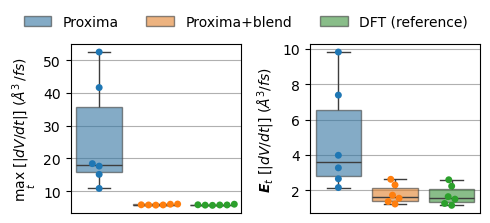

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(5,2))
labels = ['$\max_t$ $[|dV/dt|]$ ($\AA^3/fs$)', 
          r'$\boldsymbol{E}_t$ $[|dV/dt|]$ ($\AA^3/fs$)']
for i, var in enumerate(['diff_max', 'diff_mean']):
    plt.sca(axs[i])
    ax = plt.gca()
    sns.boxplot(x='Method', 
                y=var,
                data=params,
                hue='Method',
                boxprops=dict(alpha=.6),
                showfliers=False,
                legend=i,
                ax=ax
               )
    sns.swarmplot(x='Method', 
                y=var,
                data=params,
                hue='Method',
                ax=ax
                #marker='Method',
               )
    plt.ylabel(labels[i])
    plt.xlabel('')
    plt.xticks([])
    plt.grid('on', which='both')
    # plt.legend()
    #plt.ylim(bottom=0)
plt.tight_layout()
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor=(1, 1.25), ncol=3, title=None, frameon=False,
)
plt.savefig('volume_gradients.png', dpi=500, bbox_inches='tight')
plt.show()


In [21]:
ax

<Axes: ylabel='$\\boldsymbol{E}_t$ $[|dV/dt|]$ ($\\AA^3/fs$)'>

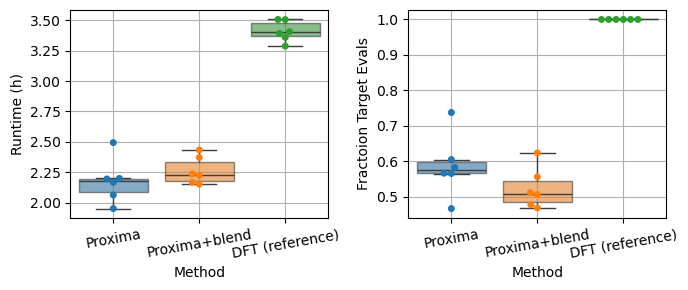

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(7,3))
labels = ['Runtime (h)', 
          r'Fractoion Target Evals']
for i, var in enumerate(['runtime_h', 'target_evals']):
    plt.sca(axs[i])
    sns.boxplot(x='Method', 
                y=var,
                data=params,
                hue='Method',
                boxprops=dict(alpha=.6),
                showfliers=False
               )
    sns.swarmplot(x='Method', 
                y=var,
                data=params,
                hue='Method',
                #style='Method',
               )
    plt.ylabel(labels[i])
    plt.xticks(rotation=10)
    plt.grid('on', which='both')
plt.tight_layout()
plt.show()

/tmp/ipykernel_212343/1726218294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _data['Method'] = _data['Method'].cat.remove_unused_categories()


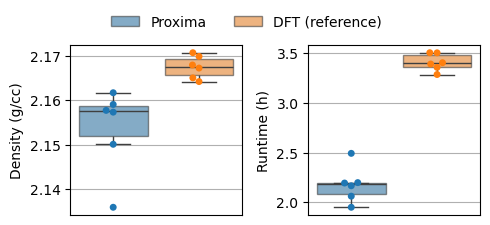

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(5,2))
labels = [r'Density (g/cc)', 
          r'Runtime (h)']

_data = params.query('Method != "Proxima+blend"')
_data['Method'] = _data['Method'].cat.remove_unused_categories()

for i, var in enumerate(['density', 'runtime_h']):
    plt.sca(axs[i])
    ax = sns.boxplot(x='Method', 
                y=var,
                data=_data,
                hue='Method',
                boxprops=dict(alpha=.6),
                showfliers=False,
                legend=i
               )
    sns.swarmplot(x='Method', 
                y=var,
                data=_data,
                hue='Method',
               )
    plt.ylabel(labels[i])
    plt.xlabel('')
    plt.xticks([])
    plt.grid('on', which='both')
plt.tight_layout()
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor=(0.5, 1.25), ncol=3, title=None, frameon=False,
)
plt.show()

In [24]:
marker_dict = {
    'Proxima': 'o', 
    'Proxima+blend': 'v',
    'DFT (reference)': 'x'
}

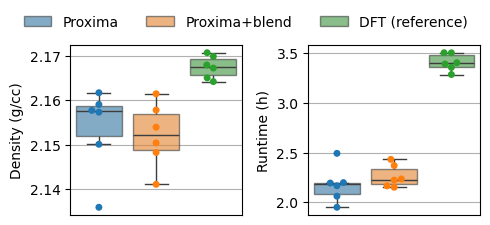

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(5,2))
labels = [r'Density (g/cc)', 
          r'Runtime (h)']

_data = params#.query('Method != "Proxima+blend"')
#_data['Method'] = _data['Method'].cat.remove_unused_categories()

for i, var in enumerate(['density', 'runtime_h']):
    plt.sca(axs[i])
    ax = sns.boxplot(x='Method', 
                y=var,
                data=_data,
                hue='Method',
                boxprops=dict(alpha=.6),
                showfliers=False,
                legend=i,
               )
    sns.swarmplot(x='Method', 
                y=var,
                data=_data,
                hue='Method',
                # legend=i,
               )
    plt.ylabel(labels[i])
    plt.xlabel('')
    plt.xticks([])
    plt.grid('on', which='both')
plt.tight_layout()
sns.move_legend(
    ax, "upper right",
    bbox_to_anchor=(1, 1.25), ncol=3, title=None, frameon=False,
)
plt.savefig('density_runtime.png', dpi=500, bbox_inches='tight')
plt.show()


In [26]:
ran_surrogate = data.query('used_surrogate == True and n_blending_steps == 0')

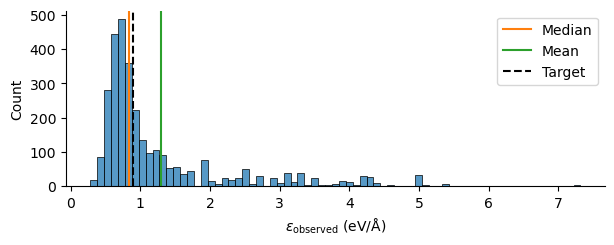

mean=1.29025, median=0.83284


In [27]:
mean, median = ran_surrogate.last_error.mean(), ran_surrogate.last_error.median()
target_error = ran_surrogate.target_error.unique()
g = sns.displot(ran_surrogate.last_error, 
                #log_scale=True,
                height=2.5, 
                aspect=5/2,
               )
g.ax.axvline(median, 
             color='tab:orange', 
             label='Median')
g.ax.axvline(mean,
             color='tab:green', 
             label='Mean')
g.ax.axvline(target_error, color='k', linestyle ='dashed', label='Target')
plt.xlabel('$\epsilon_\mathrm{observed}$ (eV/$\mathrm{\AA}$)')
plt.legend()
plt.savefig('observed_error_histogram.png', dpi=500, bbox_inches='tight')
plt.show()
print(f'{mean=:0.5f}, {median=:0.5f}')

In [28]:
ran_surrogate = data.query('proxima_blending_step == n_blending_steps and n_blending_steps == 10')
ran_surrogate.shape

(4153, 24)

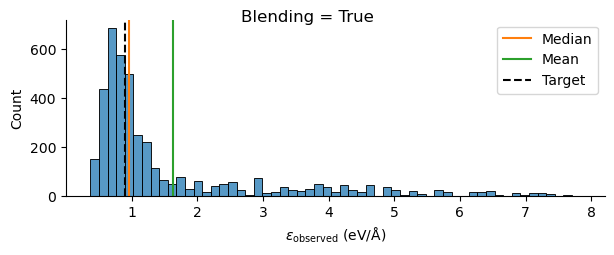

mean=1.63114, median=0.95520


In [29]:
mean, median = ran_surrogate.last_error.mean(), ran_surrogate.last_error.median()
target_error = ran_surrogate.target_error.unique()
g = sns.displot(ran_surrogate.last_error, 
                #log_scale=True,
                height=2.5, 
                aspect=5/2,
               )
g.ax.axvline(median, 
             color='tab:orange', 
             label='Median')
g.ax.axvline(mean,
             color='tab:green', 
             label='Mean')
g.ax.axvline(target_error, color='k', linestyle ='dashed', label='Target')
plt.xlabel('$\epsilon_\mathrm{observed}$ (eV/$\mathrm{\AA}$)')
plt.legend()
plt.savefig('observed_error_histogram.png', dpi=500, bbox_inches='tight')
plt.suptitle('Blending = True')
plt.show()
print(f'{mean=:0.5f}, {median=:0.5f}')